In [17]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'E:\\Datasets\\Bangla\\train\\'
test_dir = 'E:\\Datasets\\Bangla\\test\\'

train_datagen = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=15, 
#                                    width_shift_range=0.05, 
#                                    height_shift_range=0.05, 
#                                    shear_range=0.05,
#                                    zoom_range=0.05, 
#                                    horizontal_flip=True
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=32
)

Found 4000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


# Defining call back

In [11]:
class save_model_each_epoch(keras.callbacks.Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self):
        model.save('model.h5')
        print("saved")

# Defining custom metrix

In [4]:
def five_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 5,
                  K.floatx())

def ten_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 10,
                  K.floatx())


In [5]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
                 
                 
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 18,914,634
Non-trainable params: 0
_________________________________________________________________


In [15]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=125, 
                              epochs=5, 
                              validation_data=test_generator,
                              callbacks=[keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],
                              validation_steps=5)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/5
125/125 [==============================] - 13s 108ms/step - loss: 0.0303 - categorical_accuracy: 0.9922 - five_claas_diff: 0.9963 - ten_claas_diff: 1.0000 - val_loss: 0.1177 - val_categorical_accuracy: 0.9625 - val_five_claas_diff: 0.9875 - val_ten_claas_diff: 1.0000
Epoch 2/5
125/125 [==============================] - 13s 106ms/step - loss: 0.0205 - categorical_accuracy: 0.9975 - five_claas_diff: 0.9982 - ten_claas_diff: 1.0000 - val_loss: 0.1407 - val_categorical_accuracy: 0.9750 - val_five_claas_diff: 0.9875 - val_ten_claas_diff: 1.0000
Epoch 3/5
125/125 [==============================] - 13s 106ms/step - loss: 0.0158 - categorical_accuracy: 0.9955 - five_claas_diff: 0.9980 - ten_claas_diff: 1.0000 - val_loss: 0.1310 - val_categorical_accuracy: 0.9625 - val_five_claas_diff: 0.9938 - val_ten_claas_diff: 1.0000
Epoch 4/5
125/125 [==============================] - 13s 106ms/step - loss: 0.0125 - categori

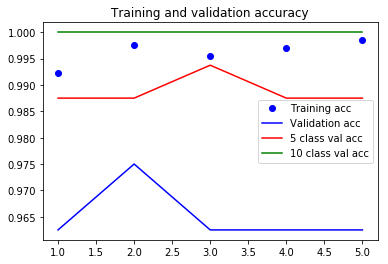

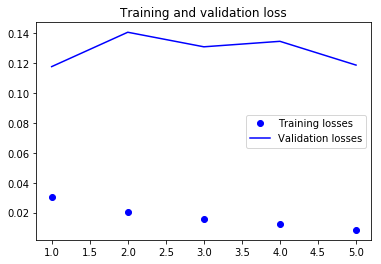

In [18]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('model_state1.h5')

In [ ]:
from keras.models import load_model
model = load_model('model_state1.h5')

# Fine tuning

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=12600, 
                              epochs=10, 
                              validation_data=test_generator, 
                              validation_steps=900)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('model.h5')